### Authors: </br>
Ruy Guzmán </br>
Fernanda de León </br>
Karla Mondragón

# LSTM

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Dataset Overview

In [2]:
df_msft = pd.read_csv('../database/ticker_MSFT.csv')
df_goog = pd.read_csv('../database/ticker_GOOG.csv')
df_v = pd.read_csv('../database/ticker_V.csv')

dflist = [df_msft, df_goog, df_v]

In [3]:
for df in dflist:
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

In [4]:
dflist

[                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2021-12-06  323.950012  327.450012  319.230011  326.190002  320.321655   
 2021-12-07  331.640015  335.799988  330.100006  334.920013  328.894592   
 2021-12-08  335.309998  335.500000  330.799988  334.970001  328.943665   
 2021-12-09  334.410004  336.489990  332.119995  333.100006  327.107300   
 2021-12-10  334.980011  343.000000  334.790009  342.540009  336.377502   
 ...                ...         ...         ...         ...         ...   
 2023-11-29  383.760010  384.299988  377.440002  378.850006  378.850006   
 2023-11-30  378.489990  380.089996  375.470001  378.910004  378.910004   
 2023-12-01  376.760010  378.160004  371.309998  374.510010  374.510010   
 2023-12-04  369.100006  369.519989  362.899994  369.140015  369.140015   
 2023-12-05  366.450012  371.390015  365.621002  371.372009  371.372009   
 
               Volume S

In [5]:
COMPANIES = ['Microsoft','Google','VISA']

In [6]:
def plotVariables(df,vars, title):
    i = 0
    for group in df:
        group[vars].plot(
            figsize=(10, 5),
            title=f"{title} - Stock: {COMPANIES[i]}",
            subplots=True,
        )
        plt.show()
        i+=1

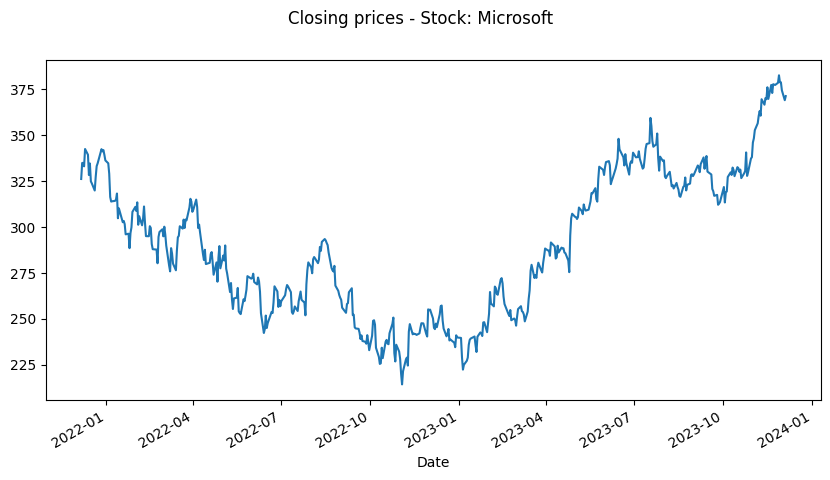

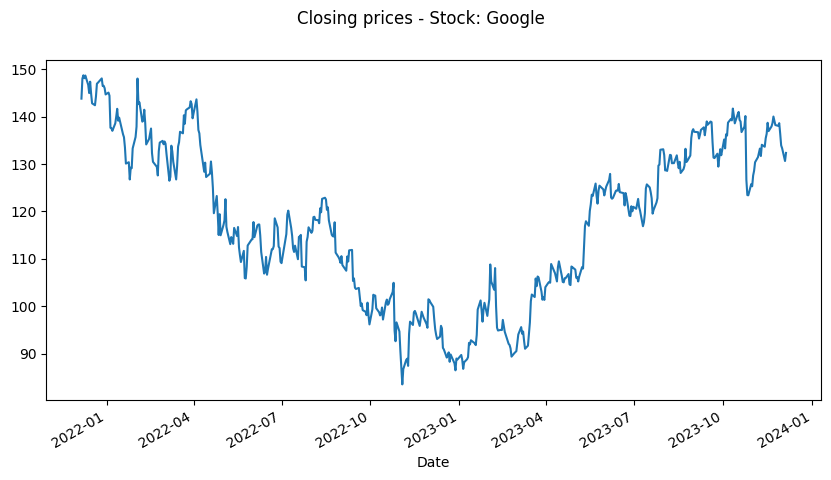

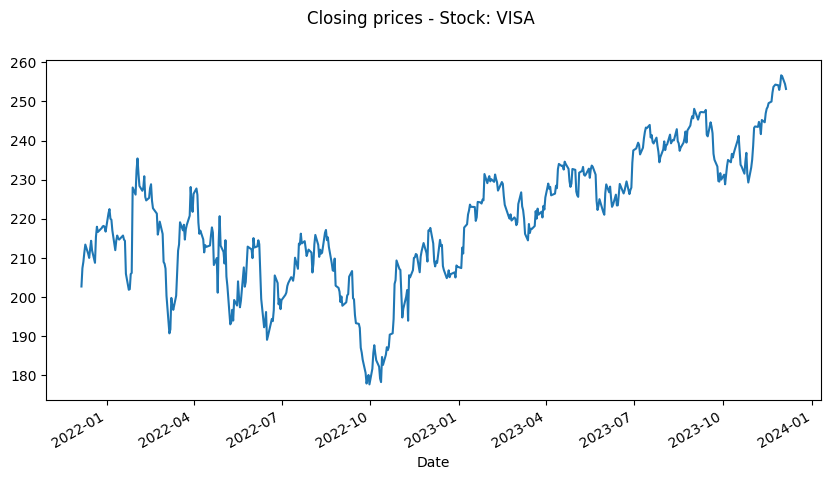

In [7]:
plotVariables(dflist,'Close', 'Closing prices')

In [8]:
for i in range(len(dflist)):
    dflist[i] =  dflist[i].drop(columns=['Open','High','Low', 'Adj Close', 'Volume'])

## Data Preprocessing

In [9]:
split_date = '2023-01-01'

''' traininig_data_msft = df_msft.loc[df_msft.index < split_date]
traininig_data_goog = df_goog.loc[df_goog.index < split_date]
traininig_data_visa = df_v.loc[df_v.index < split_date] '''

' traininig_data_msft = df_msft.loc[df_msft.index < split_date]\ntraininig_data_goog = df_goog.loc[df_goog.index < split_date]\ntraininig_data_visa = df_v.loc[df_v.index < split_date] '

In [10]:
# Normalize data
scaled_data_list = []

for df in dflist:
    # Extract training data
    training_data = df.loc[df.index < split_date]

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(training_data['Close'].values.reshape(-1, 1))

    # Append scaled data to the list
    scaled_data_list.append(scaled_data)

In [16]:
# Set the number of days used for prediction
prediction_days = 25

# Initialize empty lists for training data input and output
x_train_list = []
y_train_list = []

for scaled_data in scaled_data_list:
    # Iterate through the scaled data, starting from the prediction_days index
    for x in range(prediction_days, len(scaled_data)):
        # Append the previous 'prediction_days' values to x_train
        x_train_list.append(scaled_data[x - prediction_days:x, 0])
        # Append the current value to y_train
        y_train_list.append(scaled_data[x, 0])

# Convert the x_train_list and y_train_list lists to numpy arrays
x_train_all, y_train_all = np.array(x_train_list), np.array(y_train_list)

# Reshape x_train_all to a 3D array with the appropriate dimensions for the LSTM model
x_train_all = np.reshape(x_train_all, (x_train_all.shape[0], x_train_all.shape[1], 1))

In [18]:
def LSTM_model(input_shape):
    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))
    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

     # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

## Training

In [31]:
def initialize_and_compile_model(input_shape):
    # Initialize the LSTM model with the input shape
    model = LSTM_model(input_shape)
    model.summary()

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    
    return model

In [32]:
# Define callbacks
checkpointer = ModelCheckpoint(
    filepath='weights_best.hdf5',
    verbose=2,
    save_best_only=True
)

In [33]:
# Iterate through each dataframe in dflist
for df in dflist:
    # Extract training data
    training_data = df.loc[df.index < split_date]

    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(training_data['Close'].values.reshape(-1, 1))

    # Initialize empty lists for training data input and output
    x_train_list = []
    y_train_list = []

    # Iterate through the scaled data, starting from the prediction_days index
    for x in range(prediction_days, len(scaled_data)):
        # Append the previous 'prediction_days' values to x_train
        x_train_list.append(scaled_data[x - prediction_days:x, 0])
        # Append the current value to y_train
        y_train_list.append(scaled_data[x, 0])

    # Convert the x_train_list and y_train_list lists to numpy arrays
    x_train, y_train = np.array(x_train_list), np.array(y_train_list)

    # Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Get the input shape for the model
    input_shape = (x_train.shape[1], 1)

    # Initialize the model (assuming you've already defined initialize_and_compile_model function)
    model = initialize_and_compile_model(input_shape)

    # Fit the model with the current dataframe's training data
    model.fit(
        x_train,
        y_train,
        epochs=25,
        batch_size=32,
        callbacks=[checkpointer]
    )

Model: "sequential_394"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1171 (LSTM)            (None, 25, 50)            10400     
                                                                 
 dropout_1164 (Dropout)      (None, 25, 50)            0         
                                                                 
 lstm_1172 (LSTM)            (None, 25, 50)            20200     
                                                                 
 dropout_1165 (Dropout)      (None, 25, 50)            0         
                                                                 
 lstm_1173 (LSTM)            (None, 50)                20200     
                                                                 
 dropout_1166 (Dropout)      (None, 50)                0         
                                                                 
 dense_387 (Dense)           (None, 1)              

## Inference

In [34]:
# Initialize an empty list to store predicted prices for all dataframes
all_predicted_prices = []

# Iterate through each dataframe in dflist
for df in dflist:
    # Extract test data
    test_data = df.loc[df.index >= split_date]

    # Extract the actual closing prices from the test data
    actual_prices = test_data['Close'].values

    # Concatenate the training and test data along the 'Close' column
    total_dataset = pd.concat((df['Close'], test_data['Close']), axis=0)

    # Extract the relevant portion of the dataset for model inputs
    model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

    # Reshape the model inputs to a 2D array with a single column
    model_inputs = model_inputs.reshape(-1, 1)

    # Apply the same scaling used for training data to the model inputs
    model_inputs = scaler.transform(model_inputs)

    x_test = []

    # Iterate through the model inputs, starting from the prediction_days index
    for x in range(prediction_days, len(model_inputs)):
        # Append the previous 'prediction_days' values to x_test
        x_test.append(model_inputs[x - prediction_days:x, 0])

    # Convert the x_test list to a numpy array
    x_test = np.array(x_test)
    print("Before reshaping:", x_test.shape)
    
    # Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    print("After reshaping:", x_test.shape)

    # Generate price predictions using the LSTM model
    predicted_prices = model.predict(x_test)

    # Invert the scaling applied to the predicted prices to obtain actual values
    predicted_prices = scaler.inverse_transform(predicted_prices)

    # Append the predicted prices to the list
    all_predicted_prices.append(predicted_prices)

Before reshaping: (233, 25)
After reshaping: (233, 25, 1)
8/8 [==============================] - 1s 9ms/step
Before reshaping: (233, 25)
After reshaping: (233, 25, 1)
8/8 [==============================] - 0s 9ms/step
Before reshaping: (233, 25)
After reshaping: (233, 25, 1)
8/8 [==============================] - 0s 10ms/step


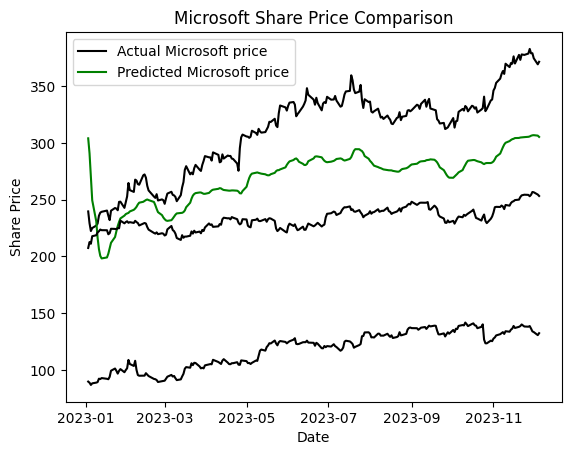

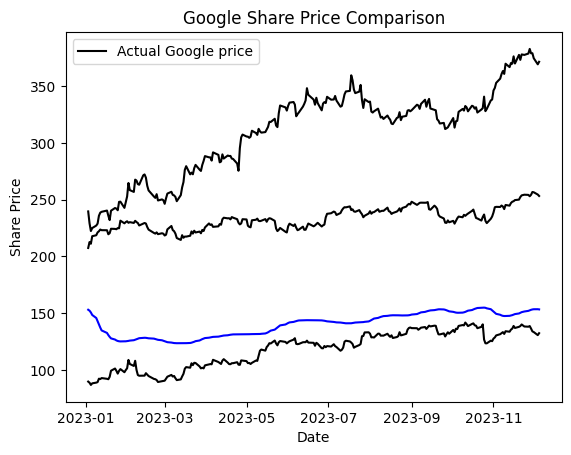

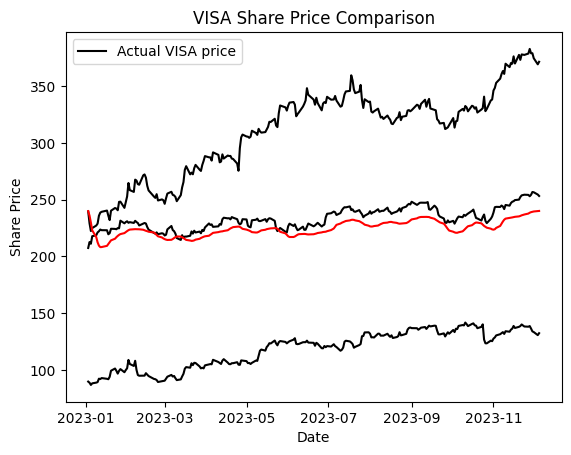

In [43]:
# Iterate through each company in COMPANIES
COMPANIES = ['Microsoft', 'Google', 'VISA']

for COMPANY in COMPANIES:
    # Create a new plot for each company
    plt.figure()

    # Iterate through each dataframe in dflist
    for i, df in enumerate(dflist):
        # Extract test data for the current company
        test_data = df.loc[df.index >= split_date]
        actual_prices = test_data['Close'].values

        # Plot the actual prices using a black line
        plt.plot(test_data.index, actual_prices, color='black', label=f"Actual {COMPANY} price" if i == 0 else "")

        # Plot the predicted prices using a different color for each company
        colors = ['green', 'blue', 'red']
        # Use separate variables for predicted prices for each company
        predicted_prices_company = all_predicted_prices[i] if COMPANY in COMPANIES[i] else None
        # Check if the company is in COMPANIES before attempting to plot
        if predicted_prices_company is not None:
            plt.plot(test_data.index, predicted_prices_company, color=colors[i], label=f"Predicted {COMPANY} price" if i == 0 else "")

    # Set the title of the plot using the company name
    plt.title(f"{COMPANY} Share Price Comparison")

    # Set the x-axis label as 'time'
    plt.xlabel("Date")

    # Set the y-axis label using the company name
    plt.ylabel("Share Price")

    # Display a legend to differentiate the actual and predicted prices
    plt.legend()

    # Show the plot on the screen for each company
    plt.show()



In [44]:
# TODO: Corregir a que sea si sube o baja

In [45]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 1s 765ms/step
Prediction: 239.5174102783203


## Performance and Accuracy Metrics

### Mean Absolute Error (MAE):

In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actual_prices, predicted_prices)
print (f"MAE for {COMPANY}", mae)

MAE for VISA 8.39389954923048


### Mean Absolute Percentage Error (MAPE):

In [ ]:
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100
print (f"MAPE for {COMPANY}", mape)

MAPE for VISA 4.69345960480549


### R-Squared (R2) Score:

In [ ]:
from sklearn.metrics import r2_score
r2 = r2_score(actual_prices, predicted_prices)
print (f"R2 for {COMPANY}", r2)

R2 for VISA 0.021852819267742185
